# Compare the optimized architecture to the actual architecture:

Import all necessary packages:

In [1]:
# Jupyter packagesb
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Common packages, you know them from before 
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import math
import copy
from typing import *
import json
import string
import os
import pickle
from pymoo_implementation.problem.problem_mlp_optimization import create_MLP_from_parameter

# Setup jupyter
%matplotlib inline

2023-02-14 11:01:42.197607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 11:01:42.511897: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-14 11:01:42.511924: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-14 11:01:43.744521: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
PATH = (os.getcwd().replace("scripts", ""))

Set constants:

In [3]:
TRAIN_DATA_COUNT = 250000
EVALUTAION_DATA_COUNT = TRAIN_DATA_COUNT

In [4]:
# Data constants
data_path_1 = PATH + "data/random1"
data_path_2 = PATH + "data/random2"
data_path_3 = PATH + "data/random3"
path_list = [data_path_1, data_path_2, data_path_3]

Read the data:

In [5]:
def get_data(data_path : string, data_count: int): 
    original_data = pd.read_csv(data_path, delimiter='\t');
    data = original_data.iloc[:
    data_count
    , 9:]
    input = data.iloc[:, :-9]
    target = data.iloc[:, -9:-7]

    return input, target, len(original_data)

input, target, lenght = get_data(data_path_3, TRAIN_DATA_COUNT)
val_input, val_target, lenght = get_data(data_path_1, EVALUTAION_DATA_COUNT)

KeyboardInterrupt: 

In [ ]:
def data_prep(model, input, target):    
    y_pred = model.predict(input)

    z_list = np.array([])
    theta_list = np.array([])

    true_z_list = np.array([])
    true_theta_list = np.array([])

    for element in y_pred:
        z_list = np.append(z_list, element[0]) 
        theta_list = np.append(theta_list, element[1])

    for element in target.values:
        true_z_list = np.append(true_z_list, element[0]) 
        true_theta_list = np.append(true_theta_list, element[1])
    
    return z_list, true_z_list

Load the model:

In [ ]:
def load_model(input_data, target_data, parameter):

    # add early stopping callback to save time
    es = EarlyStopping(monitor = 'val_accuracy', mode ='max', patience = 5)
    # Train the model
    cnn_model = create_MLP_from_parameter(parameter)
    cnn_model.fit(input_data, target_data, epochs=500, validation_split = 0.2, batch_size=2, callbacks = [es], use_multiprocessing=True, verbose=0)

    return cnn_model

In [ ]:
res = pickle.load(open(f"{PATH}pickled_data/res-ITIV-set1-20pop-6ly-2023-02-13.p", "rb"))
for history in res:
        last_best = history[-1].opt.get("X")

opt_parameter = last_best[0][:-1]
opt_parameter

array([114., 109.,  21., 113.,   0.])

In [ ]:
opt_model = load_model(input, target, opt_parameter)
old_model = load_model(input, target, np.array([81]))

2023-02-14 10:55:30.815465: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-14 10:55:30.816251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Maschine): /proc/driver/nvidia/version does not exist
2023-02-14 10:55:30.827532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


KeyboardInterrupt: 

Performace comparision plots:

7813/7813 [==============================] - 10s 1ms/step


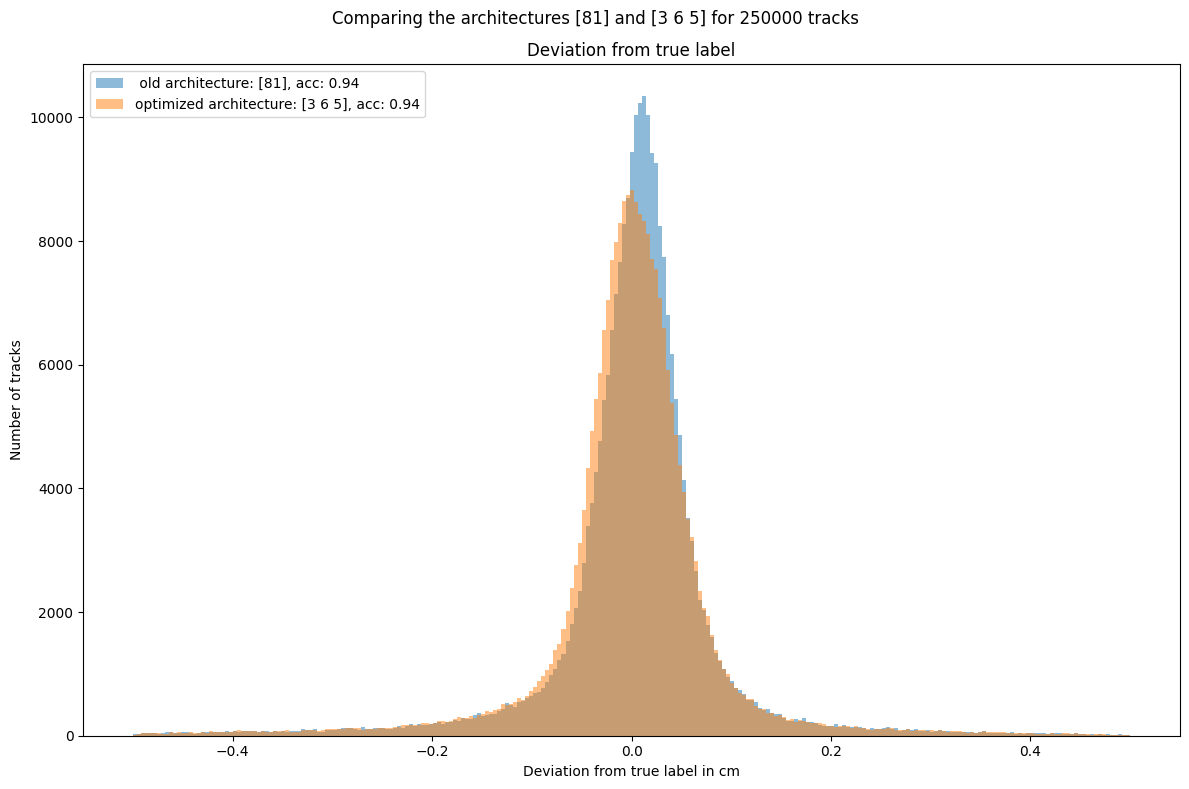

In [ ]:
def plot_z_deviation(opt_model,old_model, title, save_name, input, target):
    opt_acc = old_model.evaluate(input, target)[1]
    old_acc = opt_model.evaluate(input, target)[1]
    
    fig, ax = plt.subplots(1, 1)
    hist_bins = np.linspace(-0.5, 0.5, 250)
    fig.set_size_inches(12, 8)

    z_list_opt, true_z_list = data_prep(opt_model, input, target)
    z_list_old, true_z_list = data_prep(old_model, input, target)

    delta_z_opt = (z_list_opt).astype(float) - (true_z_list).astype(float)
    delta_z_old = (z_list_old).astype(float) - (true_z_list).astype(float)
    

    ax.set_title(f'Deviation from true label')
    ax.set_xlabel("Deviation from true label in cm")
    ax.set_ylabel("Number of tracks")

    ax.hist(delta_z_opt, hist_bins, density=False,  alpha=0.5, label=f' old architecture: [81], acc: {old_acc:0.02f}')
    ax.hist(delta_z_old, hist_bins, density=False,  alpha=0.5, label=f'optimized architecture: {opt_parameter}, acc: {opt_acc:0.02f}')
    ax.legend(loc = 'upper left')

    fig.suptitle(title)
    plt.tight_layout()
    fig.savefig(f"{PATH}/plots/{save_name}.png")
    plt.show()

plot_z_deviation(opt_model, old_model, f'Comparing the architectures [81] and {opt_parameter} for {EVALUTAION_DATA_COUNT} tracks',  f"z_deviation_{opt_parameter}", val_input, val_target)

7813/7813 [==============================] - 8s 996us/step


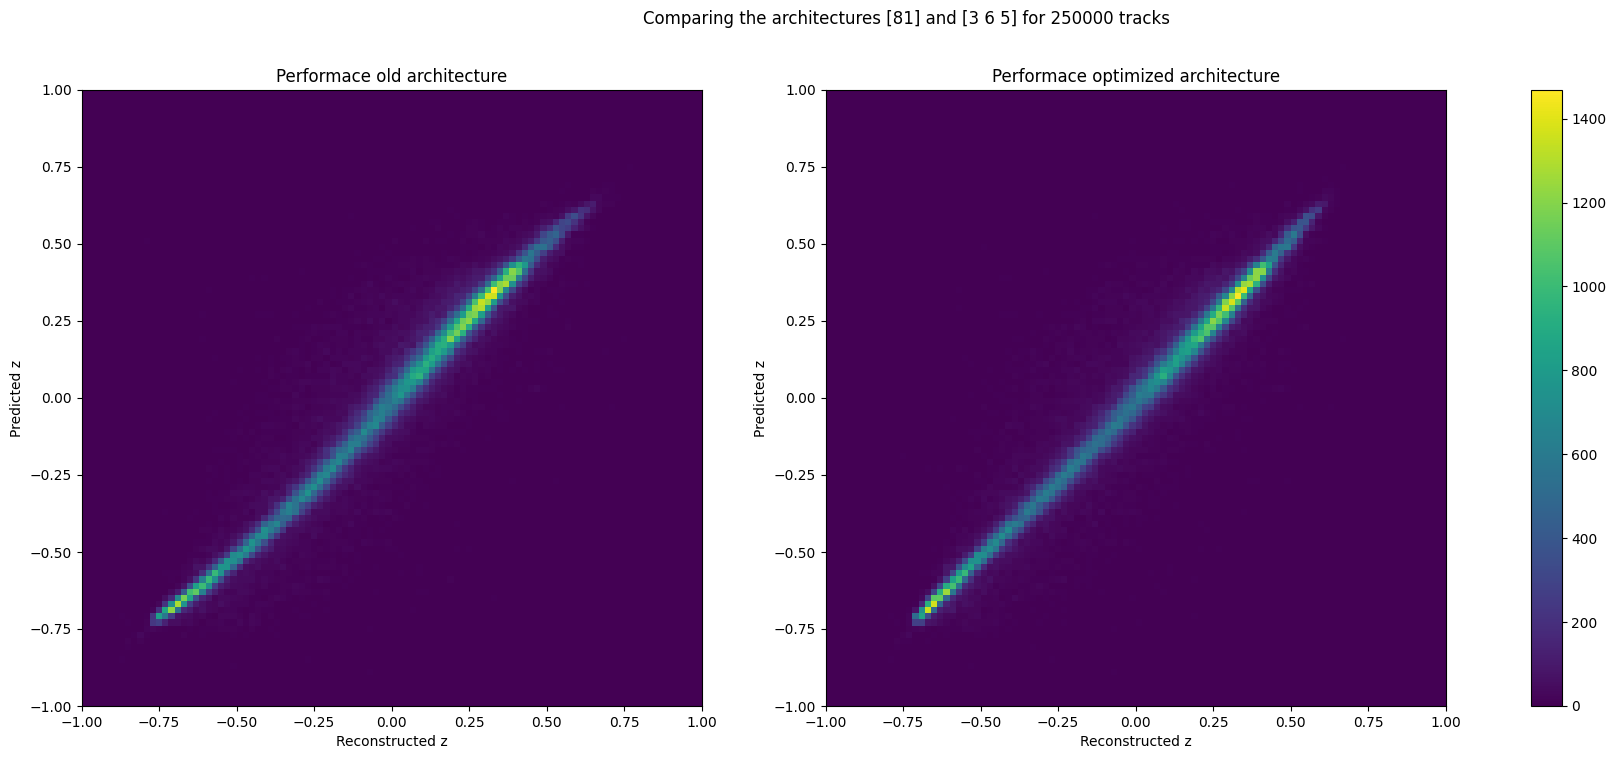

In [ ]:
def plot_prediciton_performance(opt_model,old_model, title, save_name, input, target):
    
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(22, 8)

    z_list_opt, true_z_list = data_prep(opt_model, input, target)
    z_list_old, true_z_list = data_prep(old_model, input, target)


    ax[0].set_title(f'Performace old architecture')
    ax[0].set_xlabel("Reconstructed z")
    ax[0].set_ylabel("Predicted z")

    ax[0].hist2d(z_list_old, true_z_list, 100, density = False, range=[[-1, 1], [-1, 1]])

    ax[1].set_title(f'Performace optimized architecture')
    ax[1].set_xlabel("Reconstructed z")
    ax[1].set_ylabel("Predicted z")

    plot = ax[1].hist2d(z_list_opt, true_z_list, 100, density = False, range=[[-1, 1], [-1, 1]])
    fig.colorbar(plot[3], ax=ax)

    fig.suptitle(title)
    fig.savefig(f"{PATH}/plots/{save_name}.png")
    plt.show()

plot_prediciton_performance(opt_model, old_model, f'Comparing the architectures [81] and {opt_parameter} for {EVALUTAION_DATA_COUNT} tracks',  f"performace_{opt_parameter}", val_input, val_target)

7813/7813 [==============================] - 9s 1ms/step


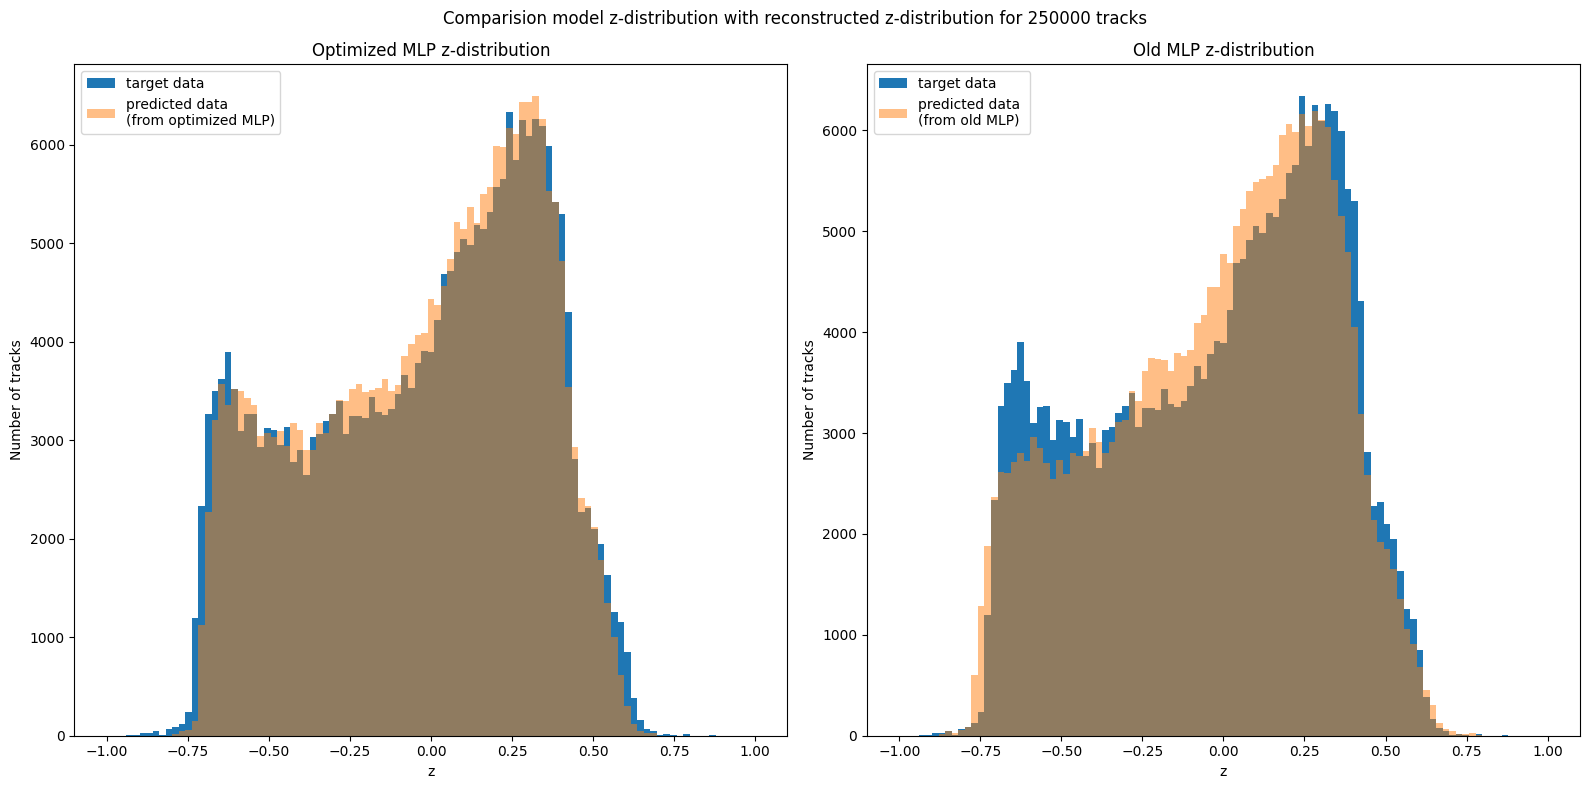

In [ ]:
def plot_z_distribution(opt_model, old_model, title, save_name, input, target):

    hist_bins = np.linspace(-1, 1, 100)
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(16, 8)

    z_list_opt, true_z_list = data_prep(opt_model, input, target)
    z_list_old, true_z_list = data_prep(old_model, input, target)

    ax[0].set_title(f'Optimized MLP z-distribution')
    ax[0].set_xlabel("z")
    ax[0].set_ylabel("Number of tracks")

    ax[1].set_title(f'Old MLP z-distribution')
    ax[1].set_xlabel("z")
    ax[1].set_ylabel("Number of tracks")
    
    
    ax[0].hist(true_z_list, hist_bins, density=False, alpha = 1, label = 'target data')
    ax[0].hist(z_list_opt, hist_bins, density=False, range=(-10, 10), alpha=0.5, label='predicted data \n(from optimized MLP)')
    
    ax[1].hist(true_z_list, hist_bins, density=False, alpha = 1, label = 'target data')
    ax[1].hist(z_list_old, hist_bins, density=False, range=(-10, 10), alpha=0.5, label='predicted data \n(from old MLP)')
    


    ax[1].legend(loc = 'upper left')
    ax[0].legend(loc = 'upper left')
    
    fig.suptitle(title)
    plt.tight_layout()
    fig.savefig(f"{PATH}/plots/{save_name}.png")
    plt.show()


plot_z_distribution(opt_model, old_model, f'Comparision model z-distribution with reconstructed z-distribution for {EVALUTAION_DATA_COUNT} tracks',  f"z_distribution{opt_parameter}", val_input, val_target )
